In [75]:
import warnings
warnings.filterwarnings("ignore")

import os
from tqdm import tqdm
import re
import numpy as np
import pandas as pd
from keybert import KeyBERT
from transformers import BertTokenizer, BertModel, BertForNextSentencePrediction, pipeline, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from konlpy.tag import Okt
import torch
import kss
import matplotlib.pyplot as plt

data_path = 'stopwords-ko.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    stop_words = set(f.read().split())
stop_words = stop_words.union(set(['을', '를', '이', '가', '은', '는', 'null', '과', '의', '그', '도', '와', '에서', '에게', '의해서', '이다', '들']))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
class nlp_before_qg:
  def __init__(self, cv_df):
    '''
    cv에서 처리한 데이터프레임과 문제 생성을 원하는 페이지 번호 입력
    ex) 1-4 형태로 페이지 번호 입력
    '''
    page_num = str(input("원하는 페이지 번호 입력(ex: 5 혹은 1-4 혹은 all): "))
    self.cv_df = cv_df
    self.page_num = page_num
    self.raw_text = None
    self.text = None
    self.text_list = None
    self.text_summary = None
    self.con_split = None
    self.key_word = None

  def raw_text_extract(self):
    df = self.cv_df
    df = df.copy()
    page_num = self.page_num
    if page_num == 'all':
      df = df.loc[df['region_type'] == '평문', ['page_number', 'region_type', 'content']]
      df.loc[:, 'content'] = df['content'].str.replace(':', '.')
      raw_text = df['content'].to_list()
      self.raw_text = raw_text
    else:
      start = 0
      end = 0
      if "-" in page_num:
        start, end = map(int,page_num.split('-'))
        end += 1
      else:
        start = int(page_num)
        end = int(page_num)+1
      page_list = range(start, end, 1)
      df = df[['page_number', 'region_type', 'content']]
      df = df.loc[df['region_type']=='평문']
      df['content'] = df['content'].str.replace('다:', '다.')
      raw_text = df.loc[df['page_number'].isin(page_list), 'content'].to_list()
      self.raw_text = raw_text

  def text_resub(self):
    '''
    리스트 형식으로 raw_text가 전달되면 불필요한 부분 제거 후 self.text에 저장(리스트 형식 반환)
    '''
    text_list = self.raw_text
    text = []
    for sent in tqdm(text_list, desc="불필요한 부분 제거", unit="sentences"):
        sent = re.sub('[^a-zA-Zㄱ-ㅣ가-힣0-9.\s()]', '', sent)
        sent = re.sub('[\n]', '', sent)
        text.append(sent)
    text = " ".join(text)
    self.text = text
    print("불필요한 부분 제거 완료")

  def split_sentence(self):
    '''
    resub를 거쳐 self.text에 저장된 텍스트를 kss로 문장 분리(리스트 형식 반환)
    '''
    text = self.text
    sentences = kss.split_sentences(text)
    self.text_list = sentences
    print("문장 분리 완료")

  def summary_sentence(self):
    '''
    요약 수행
    (hanspell을 사용하되 hanspell 라이브러리를 적당히 수정해줘야함(현재 불가))
    '''
    text = self.text_list
    device_t = 0 if device.type == "cuda" else -1
    model_name = "psyche/KoT5-summarization"
    summarizer = pipeline("summarization", model = model_name, device = device_t)
    tokenizer = AutoTokenizer.from_pretrained("psyche/KoT5-summarization")
    summary_list = []
    for t in tqdm(text, desc="요약 실행", unit="sentences"):
      tokens = tokenizer.encode(t, return_tensors="pt")
      max_length = int(len(tokens[0]))
      min_length = 30
      if max_length < min_length:
        min_length = max_length
      summary = summarizer(t, min_length = min_length, max_length = max_length, do_sample=False)[0]["summary_text"]
      summary_list.append(summary)
    self.text_summary = summary_list
    print("요약 완료")

  def context_split(self):
    '''
    문맥 구분 함수, self.text_checked에 저장된 text를 불러와 문맥을 자동적으로 구분
    문맥 별로 구분하여 리스트에 저장
    '''
    sentences = self.text_summary

    model_path = 'kobert_nsp_finetuned'
    tokenizer = BertTokenizer.from_pretrained(model_path)
    model = BertForNextSentencePrediction.from_pretrained(model_path)
    model = model.to(device)
    model.eval()

    transition_adverbs = ["그러나", "하지만", "반면", "반대로", "달리", "불구하고"]

    def get_nsp_score(sent1, sent2):
      tokens = tokenizer(sent1, sent2, return_tensors="pt", padding=True, truncation=True, max_length=128)
      tokens = {key: value.to(device) for key, value in tokens.items()}  # tokens의 텐서들을 device로 이동
      with torch.no_grad():
          outputs = model(**tokens)
      logits = outputs.logits
      prob = torch.softmax(logits, dim=1)[:, 0].item()
      return prob

    def calculate_weighted_similarity(sent1, sent2):
      nsp_score = get_nsp_score(sent1, sent2)
      dissimilarity = nsp_score
      for adverb in transition_adverbs:
        if adverb in sent2:
          dissimilarity += 0.1
      return dissimilarity

    nsp_scores = [calculate_weighted_similarity(sentences[i], sentences[i+1]) for i in range(len(sentences)-1)]
    plt.hist(nsp_scores, bins=20)
    plt.title('Distribution of NSP Scores')
    plt.xlabel('NSP Score')
    plt.ylabel('Frequency')
    plt.show()
    Q1 = np.quantile(nsp_scores, 0.25)
    Q3 = np.quantile(nsp_scores, 0.75)
    IQR = Q3-Q1
    threshold = Q3 + 1.5 * IQR
    change_points = [i for i, score in enumerate(nsp_scores) if score > threshold]
    con_split = []
    start = 0
    for change in change_points:
      con_split.append(" ".join(sentences[start:change+1]))
      start = change + 1
    con_split.append(" ".join(sentences[start:]))
    self.con_split = con_split
    print("문맥 구분 완료")

  def keybert(self):
    '''
    문맥에 따라 나누어진 self.con_split 데이터를 불러와 각 맥락마다 중요한 키워드 3개씩 추출
    '''
    con_split = self.con_split

    def mmr(doc_embedding, candidate_embeddings, words, top_n=5, diversity=0.5):
      word_doc_similarity = cosine_similarity(candidate_embeddings, doc_embedding)
      word_similarity = cosine_similarity(candidate_embeddings)
      keywords_idx = [np.argmax(word_doc_similarity)]
      candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]
      for _ in range(top_n - 1):
        if not candidates_idx:  # 후보가 없다면
          print("No more candidates left!")
          break
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)
        mmr = (1 - diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        if mmr.size == 0:  # mmr이 비어 있다면
          print("MMR array is empty!")
          break
        mmr_idx = candidates_idx[np.argmax(mmr)]
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)
      return [words[idx] for idx in keywords_idx]

    embedding_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2', device = device)
    kw_model = KeyBERT(embedding_model)
    final = []
    for text in tqdm(con_split, desc="키워드 추출", unit="contexts"):
      if not text.strip():
        final.append([])
        continue
      keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), use_maxsum=False, top_n=10)
      candidate = [key[0] for key in keywords]
      doc_embedding = embedding_model.encode([text])
      candidate_embedding = embedding_model.encode(candidate)
      key_result = mmr(doc_embedding, candidate_embedding, candidate, top_n=3, diversity=0.5)
      final.append(key_result)

    okt = Okt()
    key_total = []
    for word_list in tqdm(final, desc="불용어 처리", unit="keywords"):
      if not word_list:
        continue
      key_final = []
      for word in word_list:
        nouns = okt.nouns(word)
        for i in range(len(nouns)):
          if nouns[i] in stop_words:
              nouns[i] = ''
        joined = "".join(nouns)
        key_final.append(joined)
      key_total.append(key_final)

    self.key_word = key_total
    print("키워드 추출 완료")

  def merge_to_df(self):
    '''
    결과값 합쳐서 데이터프레임 형성
    '''
    df = pd.DataFrame(zip(self.con_split, self.key_word), columns=['context', 'keyword'])
    return df

In [79]:
class Processor:
    def __init__(self, df):
        self.df = df
        self.nbq = None
        
    def file_maker(self, path, data, format):
        if os.path.exists(path):
            user_input = input(f"File {path} already exists. Overwrite? (y/n): ").lower()
            if user_input != 'y':
                print(f"Skipping {path}")
                return
        if format == "json":        
            data.to_json(path, orient='records', force_ascii=False, indent=4)
            print(f"Final JSON results saved to: {path}")
        if format == "csv":
            data.to_csv(path, encoding = 'utf-8')
            print(f"Final CSV results saved to: {path}")

    def process_json(self):
        '''
        입력 받은 데이터프레임을 처리 후, json 파일 형식으로 반환
        '''
        if not self.nbq:
            nbq = nlp_before_qg(self.df)
            nbq.raw_text_extract()
            nbq.text_resub()
            nbq.split_sentence()
            nbq.summary_sentence()
            nbq.context_split()
            nbq.keybert()
            self.nbq = nbq
            new_df = nbq.merge_to_df()
        else:
            new_df = self.nbq.merge_to_df()
        final_path_json = os.path.join('output', 'final.json')    
        self.file_maker(final_path_json, new_df, 'json')
        
    
    def process_csv(self):
        '''
        입력 받은 데이터프레임을 처리 후, csv 파일 형식으로 반환
        '''
        if not self.nbq:
            nbq = nlp_before_qg(self.df)
            nbq.raw_text_extract()
            nbq.text_resub()
            nbq.split_sentence()
            nbq.summary_sentence()
            nbq.context_split()
            nbq.keybert()
            self.nbq = nbq
            new_df = nbq.merge_to_df()
        else:
            new_df = self.nbq.merge_to_df()
        final_path_csv = os.path.join('output', 'final.csv')
        self.file_maker(final_path_csv, new_df, 'csv')

In [81]:
def main():

    input_dir = 'source_data'
    with os.scandir(input_dir) as entries:
        json_files = [entry.name for entry in entries if entry.is_file() and entry.name.endswith('.json')]
    
    if not json_files:
        print("해당 디렉토리에 폴더가 없습니다.")
        return None

    print("사용 가능한 json 폴더 목록:")
    for idx, folder in enumerate(json_files, 1):
        print(f"{idx}. {folder}")

    while True:
        try:
            choice = int(input("사용할 폴더 번호를 입력하세요: ")) - 1
            if 0 <= choice < len(json_files):
                selected_file = json_files[choice]
                break
            else:
                print("잘못된 번호입니다. 다시 입력해주세요.")
        except ValueError:
            print("숫자를 입력해주세요.")

    selected_path = os.path.join(input_dir, selected_file)

    input_df = pd.read_json(selected_path)
    
    nlp = Processor(input_df)

    while True:
        try:
            data_format = str(input("원하는 파일 형식 지정(json/csv/both): ")).lower()
            if data_format == "json":
                nlp.process_json()
                break
            elif data_format == "csv":
                nlp.process_csv()
                break
            elif data_format == "both":
                nlp.process_json()
                nlp.process_csv()
                break
            else:
                print("잘못된 입력입니다. 다시 입력해주세요.")
        except ValueError:
            print("다시 입력해주세요.")

사용 가능한 json 폴더 목록:
1. corrected_ocr.json
2. result.json


사용할 폴더 번호를 입력하세요:  1
원하는 파일 형식 지정(json/csv/both):  both
원하는 페이지 번호 입력(ex: 5 혹은 1-4 혹은 all):  all


불필요한 부분 제거: 100%|███████████████████████████████████████████████████████████████| 35/35 [00:00<?, ?sentences/s]


불필요한 부분 제거 완료
문장 분리 완료


Device set to use cuda:0
요약 실행: 100%|████████████████████████████████████████████████████████████████| 48/48 [01:39<00:00,  2.07s/sentences]


요약 완료


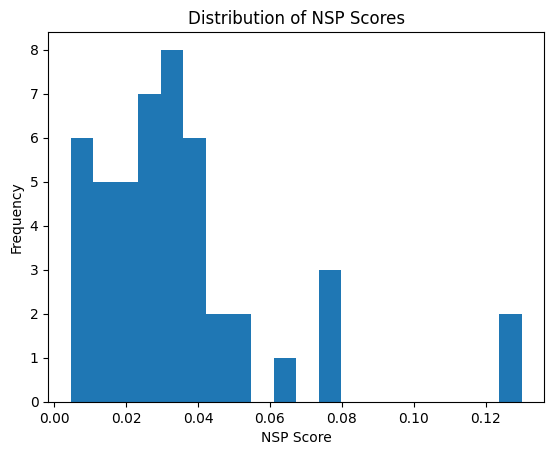

문맥 구분 완료


불용어 처리: 100%|████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 250.66keywords/s]


키워드 추출 완료


File output\final.json already exists. Overwrite? (y/n):  y


Final JSON results saved to: output\final.json


File output\final.csv already exists. Overwrite? (y/n):  y


Final CSV results saved to: output\final.csv


In [83]:
main()